#1. Setup Enviroment
Run these 2 scripts to get started!


In [ ]:
#Install the required packages and Eratos SDK (This takes about 1 minute to install everything)

%%capture
!pip install https://releases.eratos.com/sdk/python/eratos-python-latest.zip
!pip install geopandas
!pip install git+https://github.com/eratosio/eratos-xarray.git

print('The Eratos SDK and requred packages are installed')

In [ ]:
# Import requred packages

#Credentials packages
from eratos.creds import AccessTokenCreds
from eratos.adapter import Adapter
from getpass import getpass

#Processing packages
import xarray as xr
import eratos_xarray
import numpy as np
import matplotlib.pyplot as plt


#2. Get Authenticated

To access eratos datasets you will need credentials.

<a href="https://docs.eratos.com/v3.0/docs/generating-an-access-key" target="_blank">**Click here to get your credentials.**</a>

After running the below cell, please Insert your Eratos Development Key ID and Key Secret as requested.

In [ ]:
#Authenticate with Eratos
eratos_id = getpass('Enter the eratos key id:')
eratos_secret = getpass('Enter the eratos secret:')

ecreds = AccessTokenCreds(
  eratos_id,
  eratos_secret)

eadapter = Adapter(ecreds)

print('You have successfully entered key and secret, you can now continue on below')

#3. Get your dataset's Eratos Resource Name (ERN)

##What is an ERN?


Next, you will need to find the ERN for the dataset you would like to extract so Eratos knows what data you would like to access.

In this tutorial we will use the **SILO Daily Historical Rainfall Dataset**. You will need to navigate to the Eratos Marketplace to ge the ERN.

Use <a href="https://docs.eratos.com/v3.0/docs/find-data-in-marketplace" target="_blank">**this tutorial**</a> to help you find the ERN on the marketplace.

Come back here once you have the ERN, put it below and run the codeblock.

In [ ]:
found_ern = "PUT FOUND ERN HERE"

#4. Accessing data using eratos_xarray

The easiest way to access Eratos geospatial datasets is using the Eratos implementation of xarray. This impentation inherents xarray methods for use within Eratos.

For more information about what you can do and how using xarray see these resources:
- https://docs.xarray.dev/en/stable/
- https://chat.openai.com/


**TOP TIP**: Printing the dataset (before loading) allows you to see the variables and coordinates you will need to use to access subsets of the dataset. Accessing datasets will require you to use exact variable and coordinate names.

In [ ]:
# First, open the dataset using the ERN you sourced,
# if you couldnt find it but would still like to continue, paste this one above: "ern:e-pn.io:resource:eratos.blocks.silo.dailyrainfall"

#Printing the dataset once opened will print its metadata
dataset = xr.open_dataset(found_ern, eratos_auth=ecreds)
print(dataset)

#5. Get timeseries data at a point

Its now time to extract your first set of Eratos data! In this example we are going to explore the recent flash flooding in Tully, QLD.

Most Gridded data is three-dimensional, as in, there is a data point for every place at every time (within the boundries of the dataset). the Eratos standard is to define these dimensions in Time, Latitude, and Longitude.

Using the .sel() method, we can load a subset of the full dataset. In this example we would like to get a 1D timeseries dataset that contains the amount of rain that fell every day over the flood in a single location (Tully).

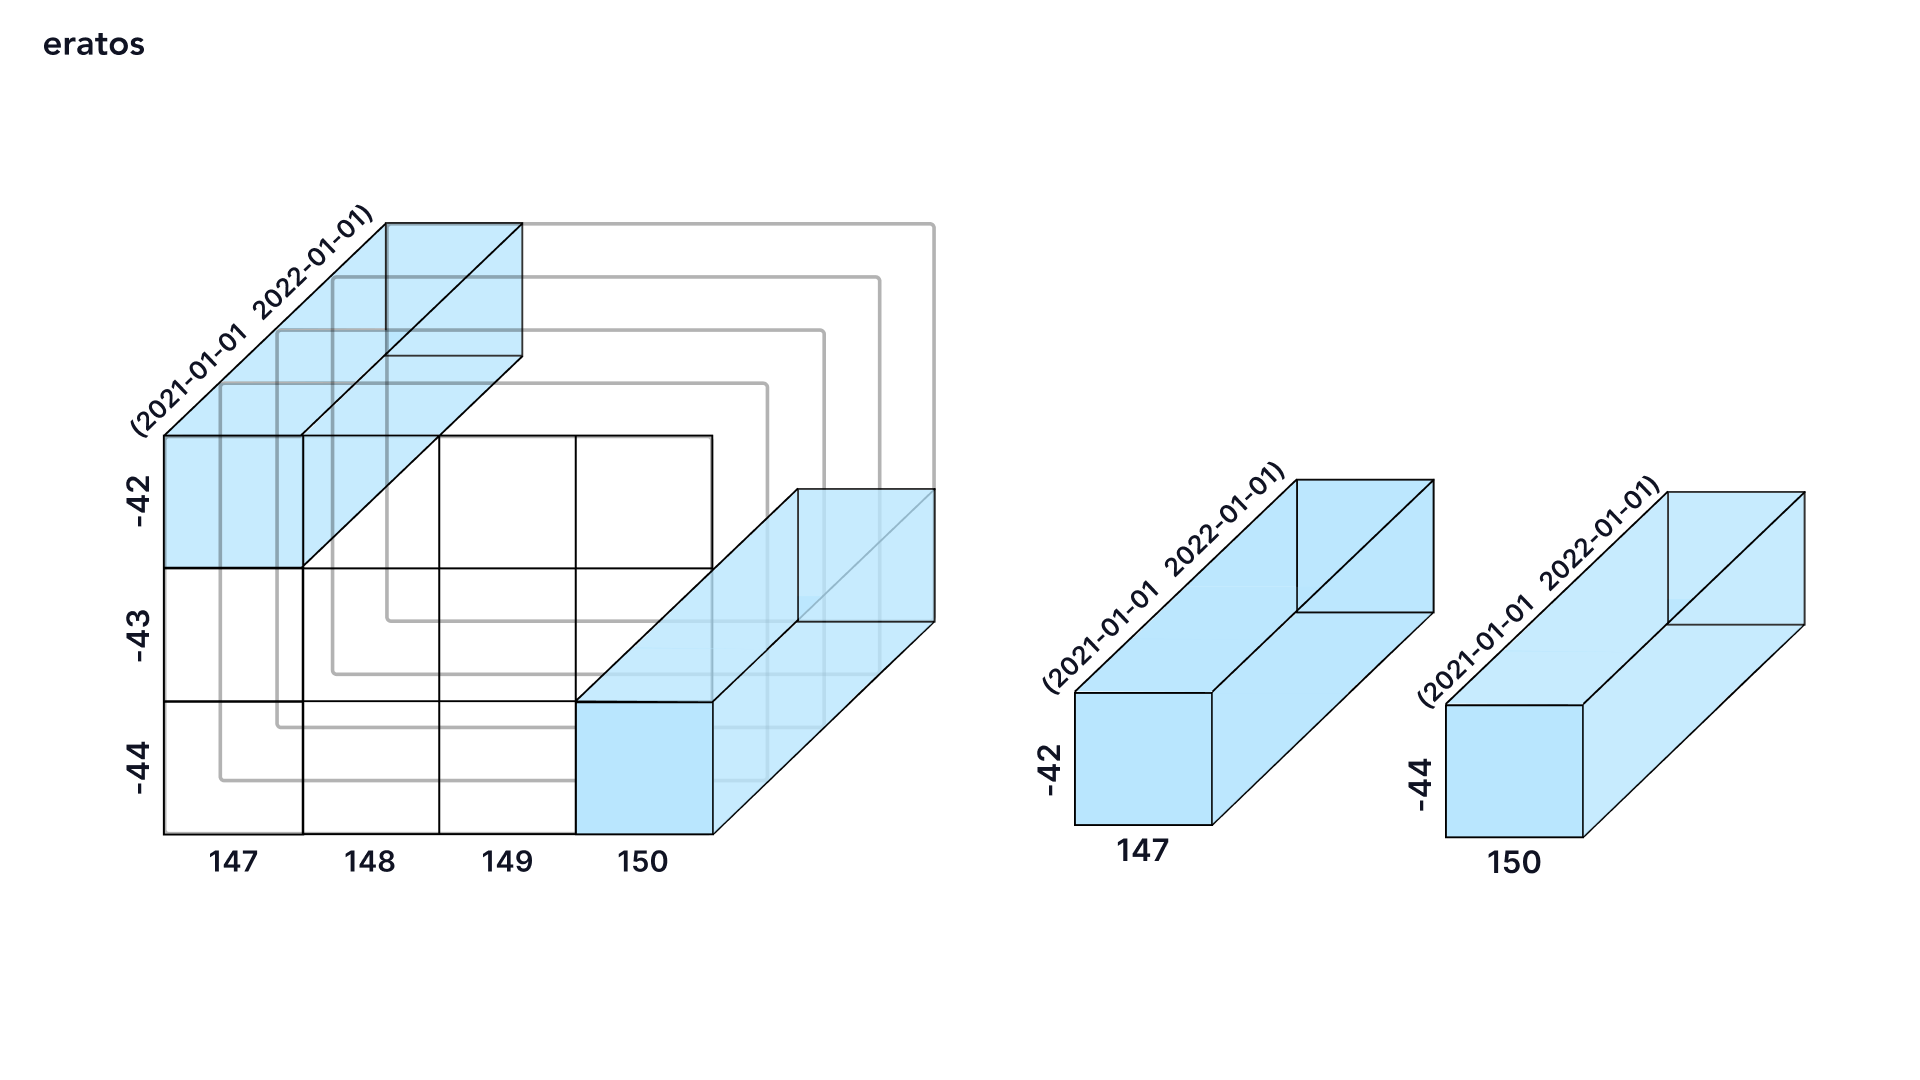

To extract the data for Tully, QLD, we need the location of the town, and the timeframe we think the flooding occured between.
For the **Daily Historical Rainfall - Australia** dataset, try these values to analyse the event:

- lat: -17.93
- long: 145.92
- start date: "2024-02-22"
- end date: "2024-02-27"

**! Warning !** Failure to select a subset of the dataset may result in loading a very large dataset in its entirety. Make sure you understand the dataset you are tying to access.

In [ ]:
lat_point =    #<PUT LAT HERE>
lon_point =    #<PUT LON HERE>
start_time =   #<PUT START HERE> in ""
end_time =     #<PUT END HERE>   in ""

#The .sel function expects a range, so we will create a range around the point. You may need to change resolution depending on the resolution of your dataset so that you only get one lat and lon.
resolution = 0.02
lat_range = (lat_point - resolution, lat_point + resolution)
lon_range = (lon_point - resolution, lon_point + resolution)

#Extract the data
bars_point = dataset.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(start_time, end_time))

# Load the subset bars
bars_point.load()

print(bars_point)

#6. Visualising your data

Its a good idea to plot your data if you can to make sure you have extracted what you expected.

For this tutorial we will use matplotlib package to plot the daily rainfall in Tully over the flash flood.

In [ ]:
#Create a plot, label used for the legend.
bars_point["daily_rain"].plot(label='Rainfall (mm)')

#Define plot labels
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.legend()

#Show plot
plt.show()

#7. Get geospatial data across an area

We would now like to understand if this flash flood was a widespread or localised event. To do this we will now extract a 2D geospatial grid of data around Tully on the 24/02/2024.

A 2D geospacial grid is a set of data points that correspond to an area at a point in time.

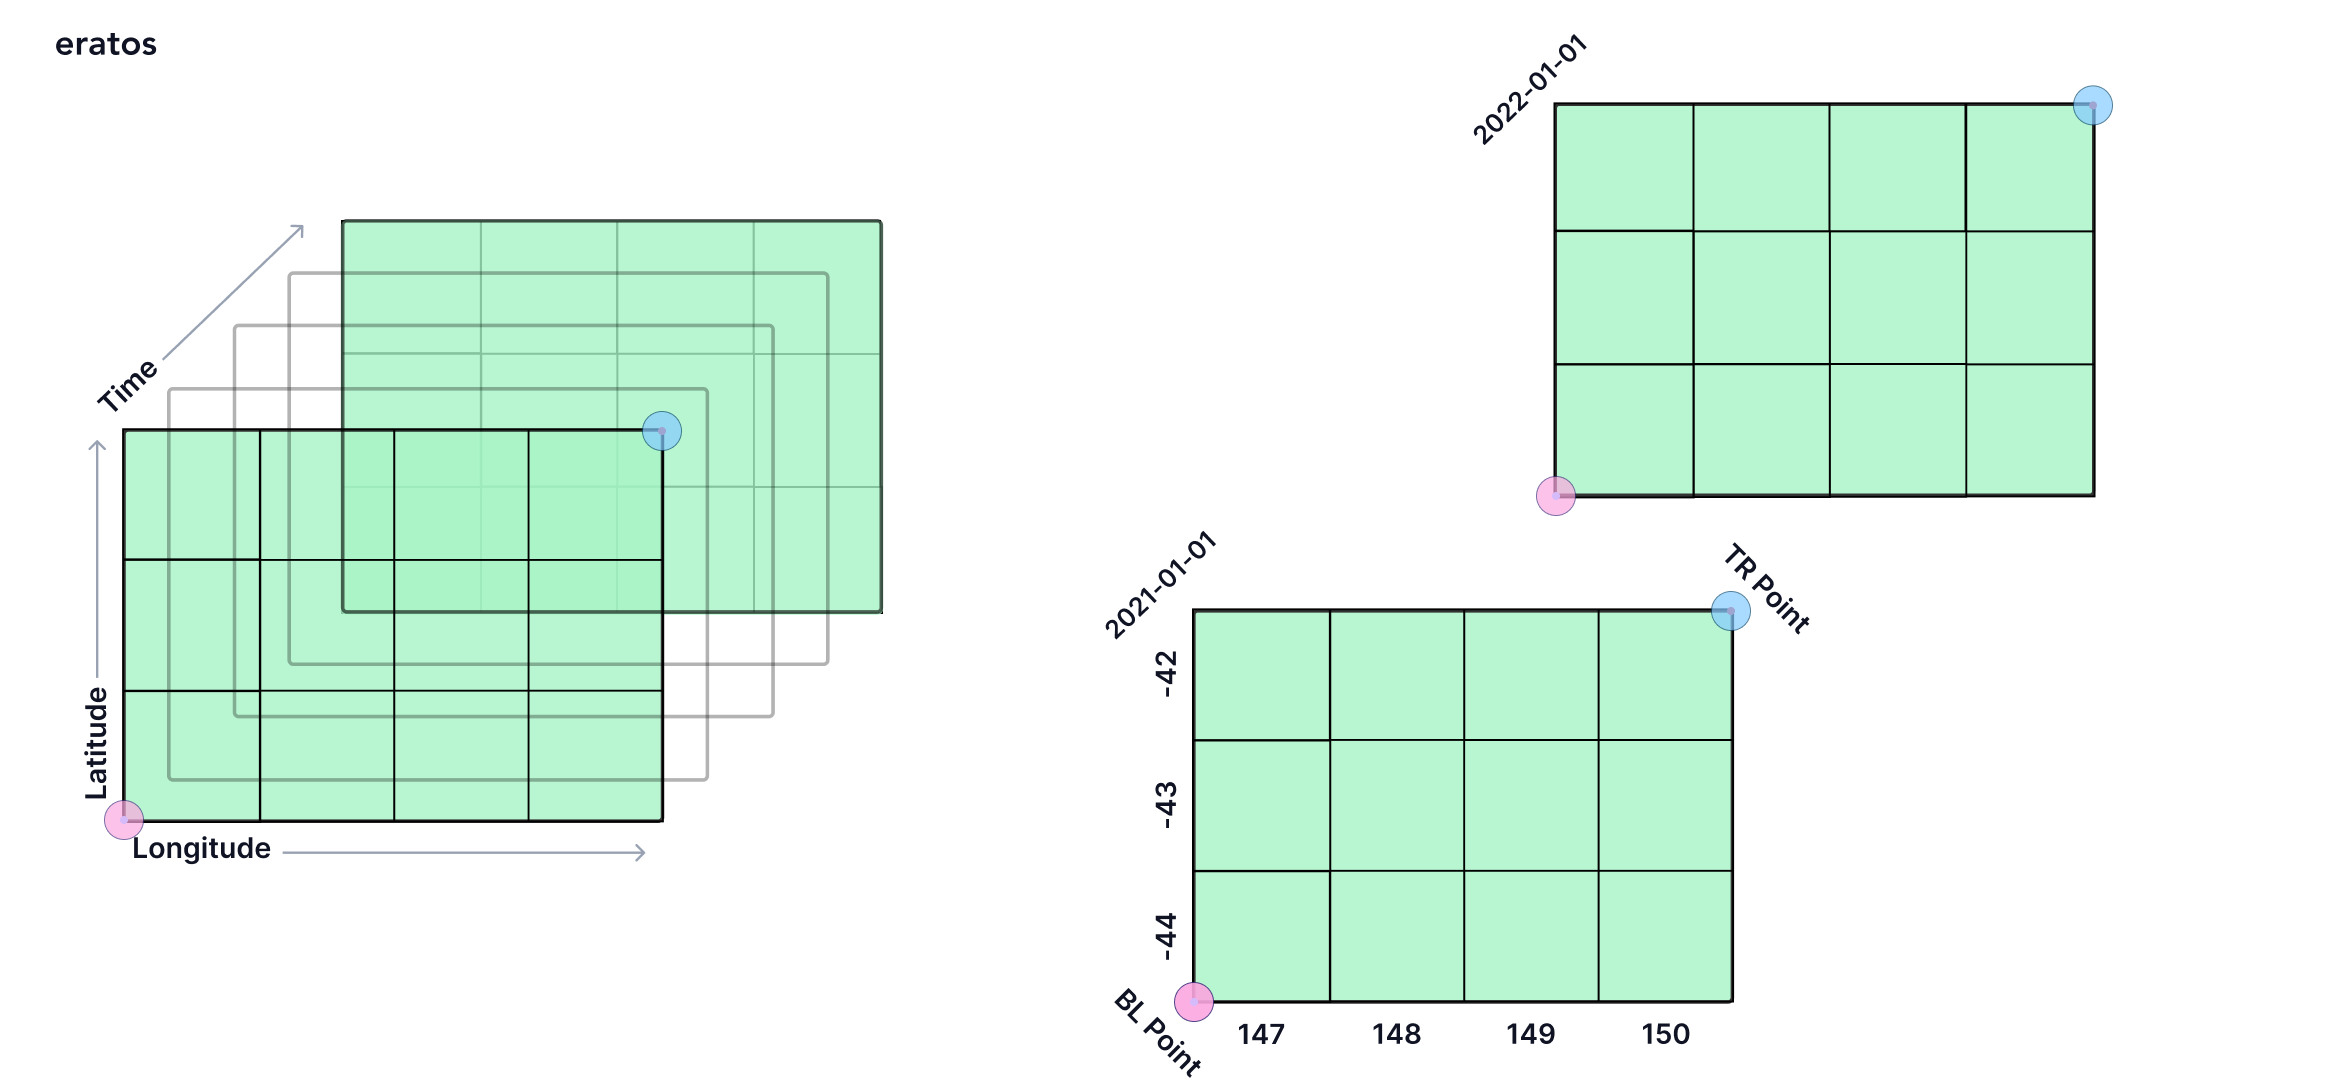

To do this we can modify our .sel() function to extract a different subset of data by inputing a range of lats and lons as Tuples (lat_min,lat_max) and (lon_min, lon_max)

For the **Daily Historical Rainfall - Australia** dataset we will extract an area around Tully on the 24/02/2024.
- lats: -18.5, -17.5
- lons: 145.5, 146.5
- time: "2024-02-24"

In [ ]:
lat_range =   #<PUT LAT Tuple HERE>
long_range =  #<PUT Long Tuple HERE>
time_point =  #<PUT TIME HERE> in ""

#Extract the data
bars_region = dataset.sel(lat=slice(*lat_range), lon=slice(*long_range),time=slice(time_point, time_point))

#Load the subset bars
bars_region.load()
print(bars_region)

Great, you now have the data stored in bars_region.

Now lets visualise the data so we can determine the locality of the flooding event.

In [ ]:
#Create a plot, label used for the legend.
bars_region["daily_rain"].plot(vmin=0)

#Define plot labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rainfall Centred on Tully, QLD')

#Show plot
plt.show()

#8. Get 3D space time subset
It was localised in space and only occured in Tully!

Now lets see if it was localised acrross **both** space and time.

To do this we will modify the .sel() method again to return a set of 2D geospatial grids, one for each day within our time region.

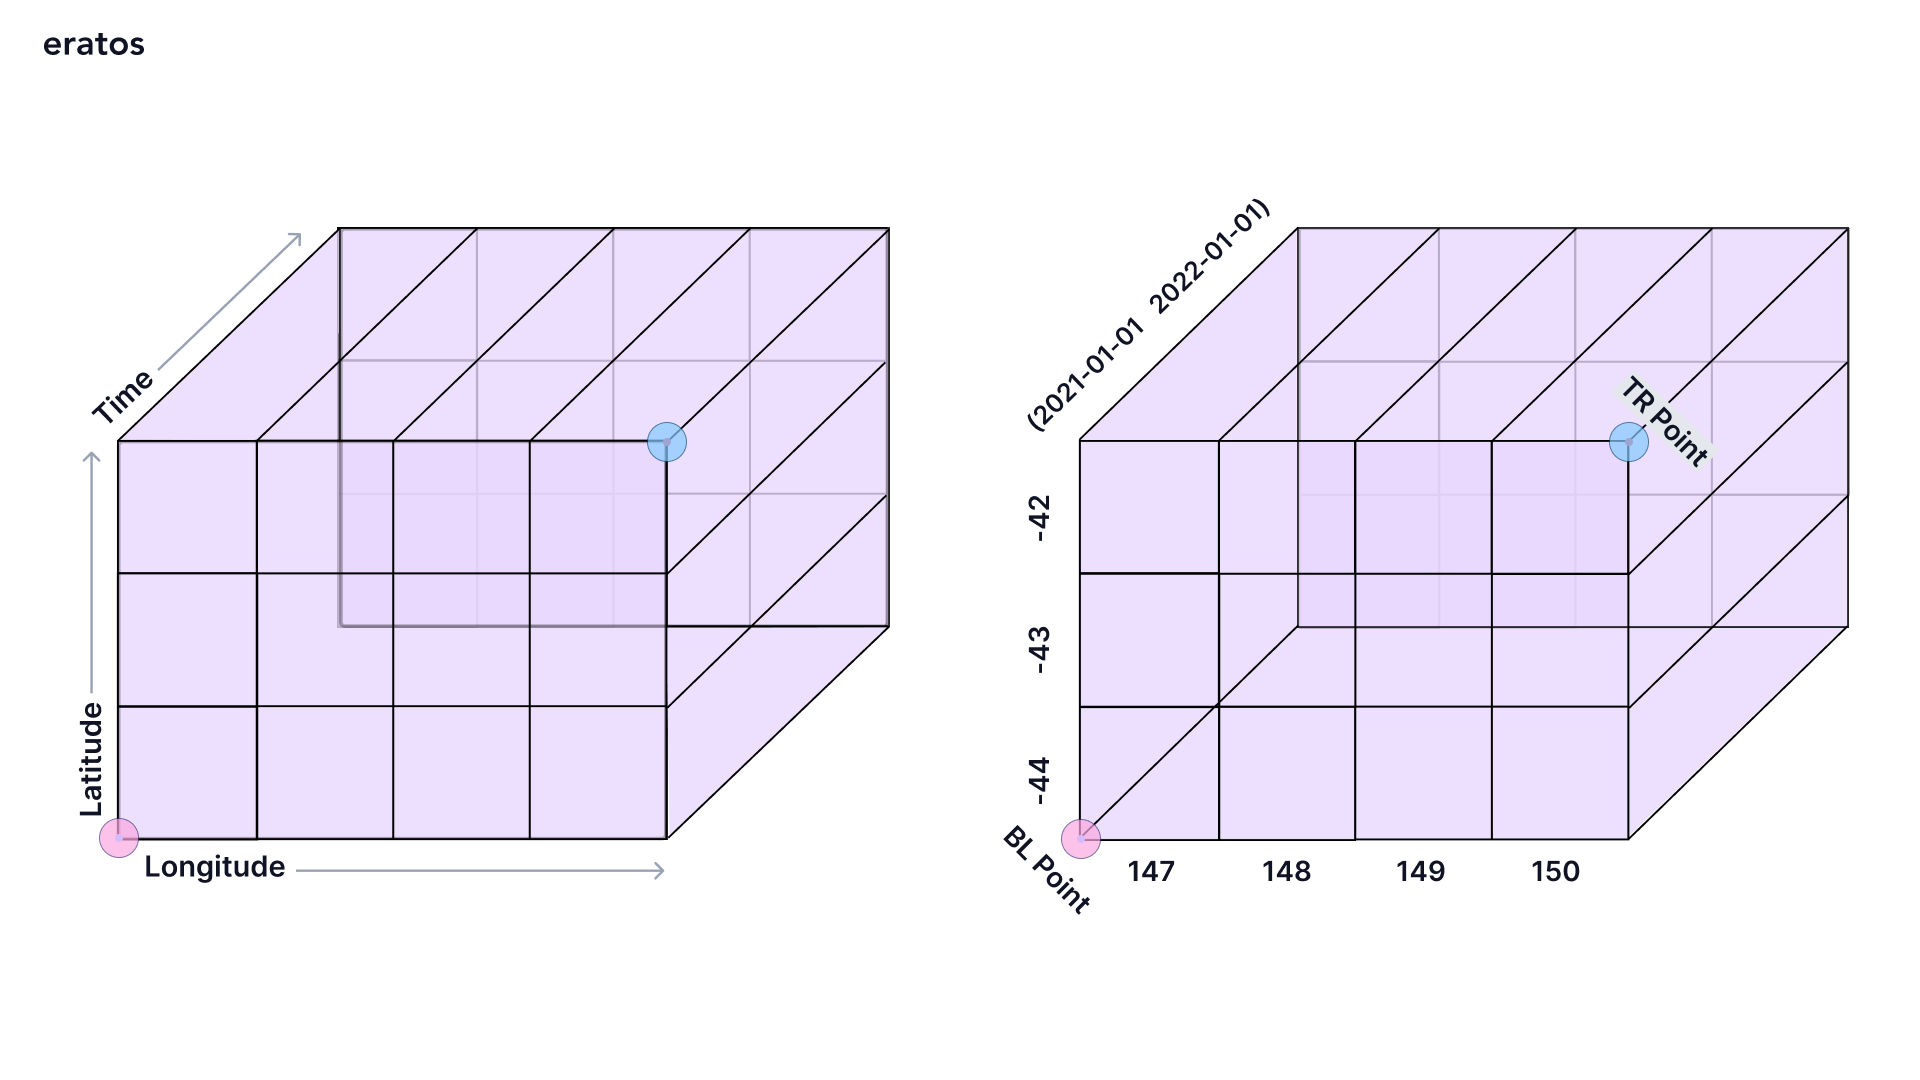

For the **Daily Historical Rainfall - Australia** dataset we will extract an area around Tully between 22/02/2024 and 27/02/2024
- lats: -18.5, -17.5
- lons:  145.5, 146.5
- time_start: "2024-02-22"
- time_end: "2024-02-27"

In [ ]:
lat_range =   #<PUT LAT Tuple HERE>
long_range =  #<PUT Long Tuple HERE>
time_start =  #<PUT TIME HERE> in ""
time_end =    #<PUT TIME HERE> in ""

bars_region_over_time = dataset.sel(lat=slice(*lat_range), lon=slice(*long_range),time=slice(time_start, time_end))

#Load the subset bars
bars_region_over_time.load()
print(bars_region_over_time)

And finally, visualising this dataset.

In [ ]:
#Create the plot, note vmin and max define the colour grading
bars_region_over_time['daily_rain'].plot(x='lon', y='lat', col='time', col_wrap=3, vmin=0, vmax=500)

#Show the plot
plt.show()

#8. Congratulations! You have completed the Accessing Data Quickstart Colab

<a href="https://docs.eratos.com/v3.0/docs/access-and-use-data-onboarding-complete" target="_blank">**Follow This Link**</a> to complete your onboarding and discover more powerful Eratos functionality.